# BayFlux Analysis of command line output
By Tyler W. H. Backman

In [1]:
%matplotlib inline

In [2]:
from pymc import gelman_rubin
import matplotlib.pyplot as plt
import matplotlib
import cobra
import os
import math
from cobra.flux_analysis import flux_variability_analysis
import bayflux
import pandas as pd
import numpy as np
import re
from scipy.stats import norm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import ntpath
from cobra.sampling import MCMCACHRSampler
sns.set(style="white")
print(cobra.__version__)
pd.set_option('display.max_rows', 1000)

0.18.1


In [3]:
matplotlib.rcParams['figure.figsize'] = (16,8)

In [4]:
# Specify config file
configFile = 'pgi16h.yaml'

In [5]:
# parse config file into variable configData
with open(configFile, 'r') as stream:
    try:
        configData = yaml.safe_load(stream)
    except yaml.YAMLError as exception:
        print(exception)

In [6]:
# get list of existing output files we could resume from
outputFolder = ntpath.dirname(configData['outputBaseName'])

files = os.listdir(outputFolder) 
matchingFiles = list(filter(lambda x: re.match('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy$', x), files))
fileNameIntegers = [int(re.sub('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy', r'\1', filename)) for filename in matchingFiles]

In [7]:
# for now, resume from the largest one only
resumeHere = max(fileNameIntegers)

# define function to generate an output filename from a number
def integerToFilename(outputBaseName, x, zfill=3):
    return outputBaseName + str(x).zfill(zfill) + '.npy'

In [8]:
sampleFilename = integerToFilename(configData['outputBaseName'], resumeHere)

In [9]:
# load samples
data = np.load(os.path.join(sampleFilename))

In [10]:
# compute from data shape the number of MPI chains
chains = int(data.shape[0] / configData['bayesianSamplesPerTask'])
print('found ' + str(chains) + ' markov chains!')

found 4 markov chains!


Now we convert this model to a bayflux ReactionNetwork, which inherets 'EnhancedReaction' objects from each cobra.Reaction, allowing us to add in atom transitions

In [11]:
cobrapymodel = cobra.io.read_sbml_model(configData['modelFile'])
model = bayflux.ReactionNetwork(cobrapymodel)
model

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


<ReactionNetwork iAF1260 at 0x7f474dbf3b50>

In [14]:
# Import and apply exchange fluxes from file
model.readFluxConstraints(configData['fluxBoundsFile'])

# set max flux
limit = configData['maxFlux']
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

# run FBA to confirm model works
model.optimize()

<Solution 0.204 at 0x7f474d9d6580>

In [15]:
mcmcachr = cobra.sampling.MCMCACHRSampler(model)

In [16]:
%%time
# start by warming up with samples ignoring probability to get center
# samplesToCollect = configData['centeringSamplesPerTask']
samplesToCollect = 100000
warmupSamples = mcmcachr.sample(samplesToCollect, fluxes=False, likelihood=False)
warmupSamples.shape

acceptance rate: 1.0
CPU times: user 19min 55s, sys: 1.86 s, total: 19min 57s
Wall time: 19min 57s


(100000, 1438)

In [17]:
# put the samples in a Pandas DF
realSamples = pd.DataFrame(data, columns=[v.name for v in model.variables])
del data

#### To plot marginals and trace we will just plot the last 90% of the first markov chain

In [ ]:
endOfFirstChain = int(realSamples.shape[0] / chains)
endOfFirstChain

In [ ]:
startOfFirstChain = int(endOfFirstChain * 0.10)
startOfFirstChain

In [20]:
firstChain = realSamples.iloc[startOfFirstChain:endOfFirstChain]
firstChain.shape

(90000, 1438)

In [21]:
netFirstChain = np.subtract(firstChain.iloc[:,0::2], firstChain.iloc[:,1::2])

/tmp/ipykernel_32626/559968163.py:1 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [22]:
# create a list of the reactions we want to plot fluxes for
allRxns = ['PGI','EDD','AKGDH', 'G6PDH2r']

# allRxns = [r.id for r in model.reactions][0:4]

<AxesSubplot:>

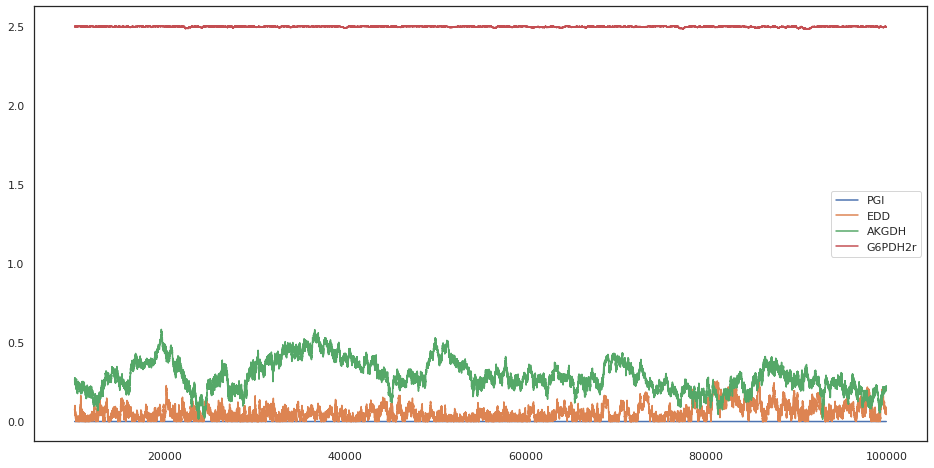

In [23]:
netFirstChain[allRxns].plot()

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/distributions.py:316 UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


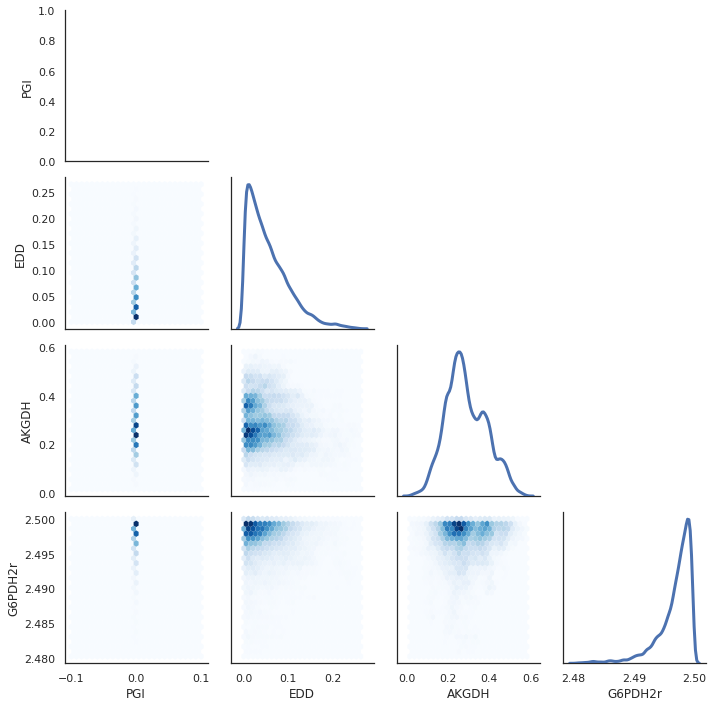

In [24]:
# plot sample distribution for samples
# start = int((realSamples.shape[0]/10))
# g = sns.PairGrid(realSamples[allRxns].iloc[start::realSampleThinning, :], diag_sharey=False)
g = sns.PairGrid(netFirstChain[allRxns], diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
g.map_diag(sns.kdeplot, lw=3, gridsize=100)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Plot marginal distributions for each reaction

Here we plot a marginal distribution for each reaction as a net flux, while excluding the first 10% of the samples, and by adding the forward and reverse fluxes to get net flux for reversible reactions.

In [25]:
# summarize the samples to be plotted

deleteStart = 0
netSamples = np.subtract(firstChain.iloc[deleteStart::1,0::2], firstChain.iloc[deleteStart::1,1::2])
netUniform = np.subtract(warmupSamples.iloc[deleteStart::1,0::2], warmupSamples.iloc[deleteStart::1,1::2])
display(netUniform.shape)
display(netSamples.shape)

/tmp/ipykernel_32626/1342583405.py:4 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
/tmp/ipykernel_32626/1342583405.py:5 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1

(100000, 719)

(90000, 719)

In [26]:
# remove reactions with no variance, e.g. they cannot carry flux or were fully constrained

rxnsWithVariance = netUniform.std(axis=0) > 0.001
netUniform = netUniform.loc[:,rxnsWithVariance]
netSamples = netSamples.loc[:,rxnsWithVariance]

In [27]:
netUniform.shape

(100000, 438)

In [28]:
warmupSampleThinning = math.ceil(warmupSamples.shape[0]/100000)
warmupSampleThinning
realSampleThinning = math.ceil(netSamples.shape[0]/100000)
realSampleThinning

1

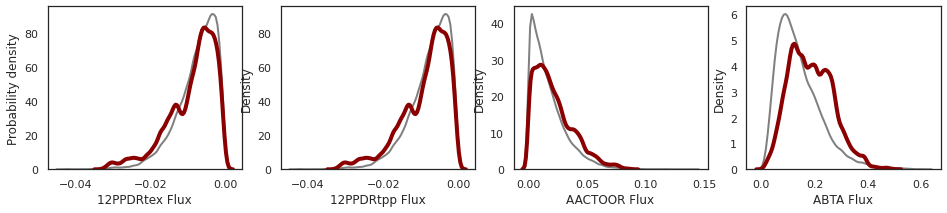

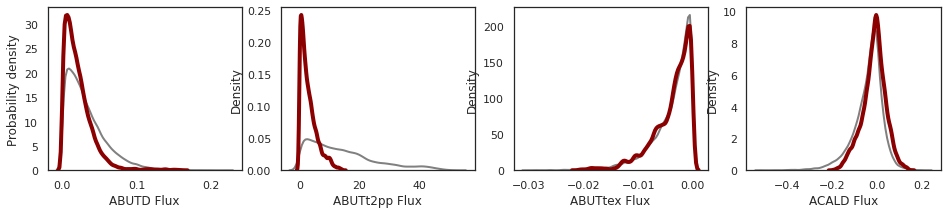

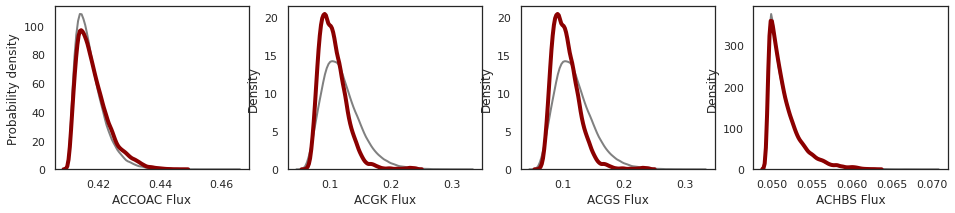

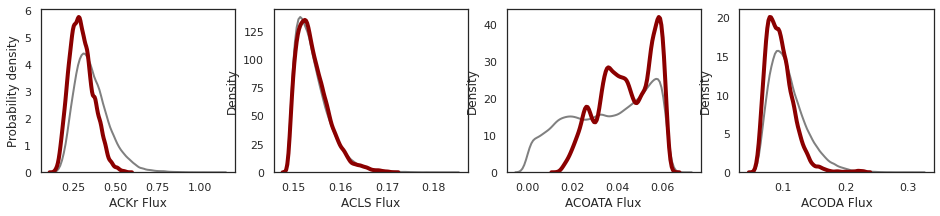

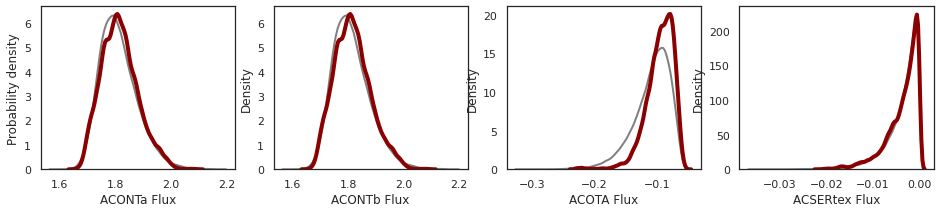

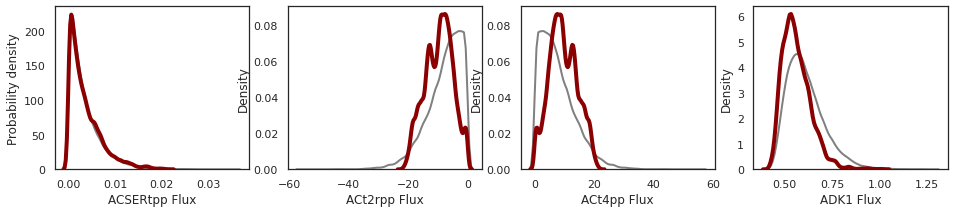

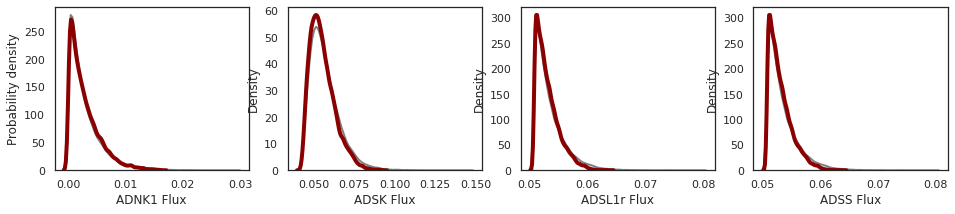

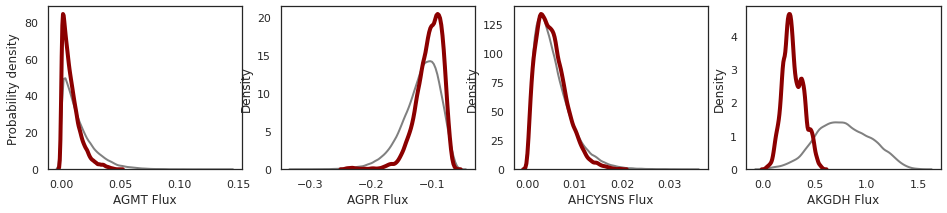

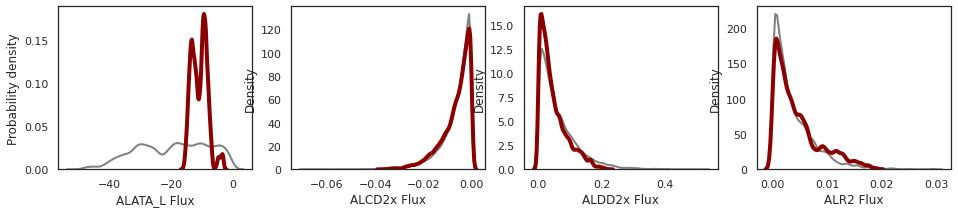

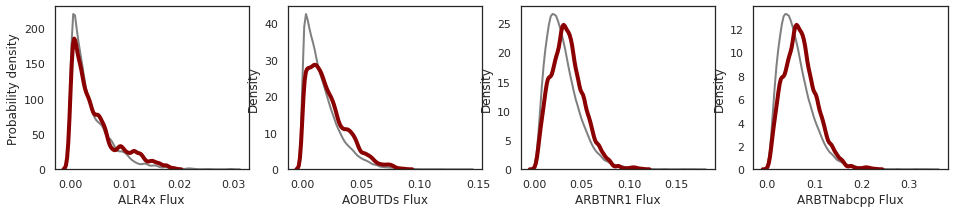

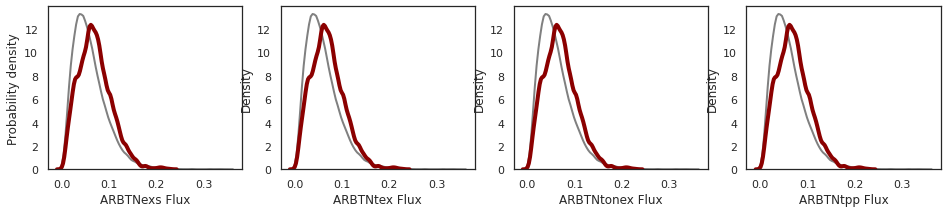

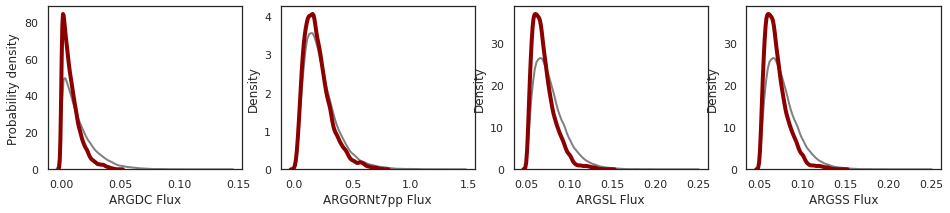

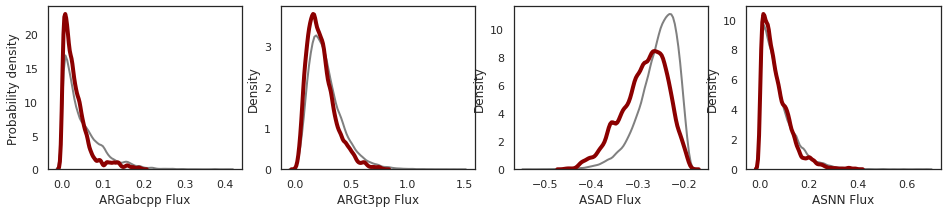

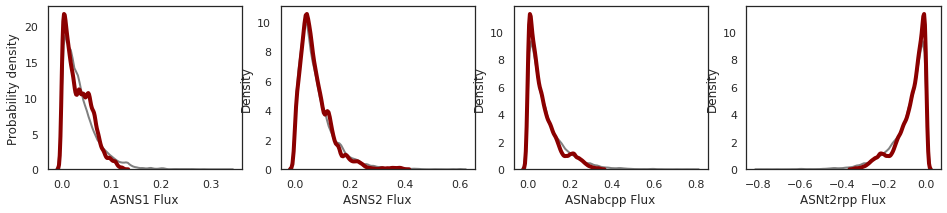

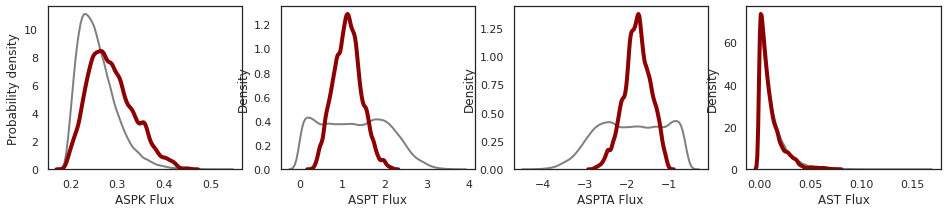

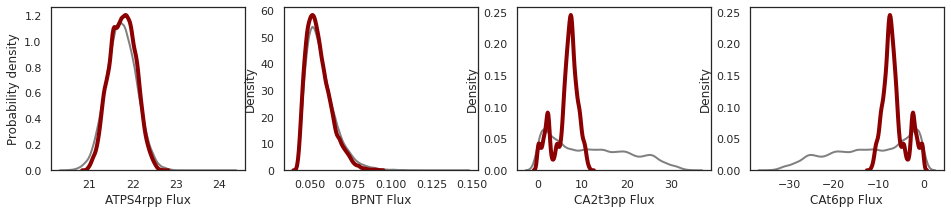

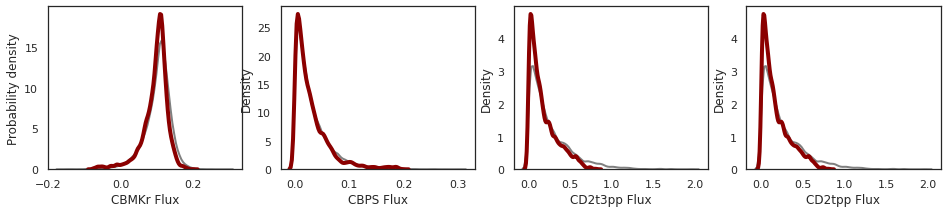

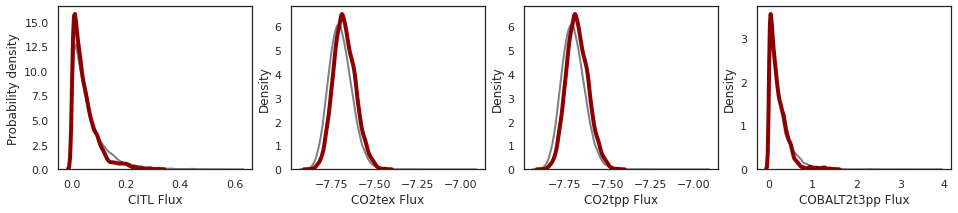

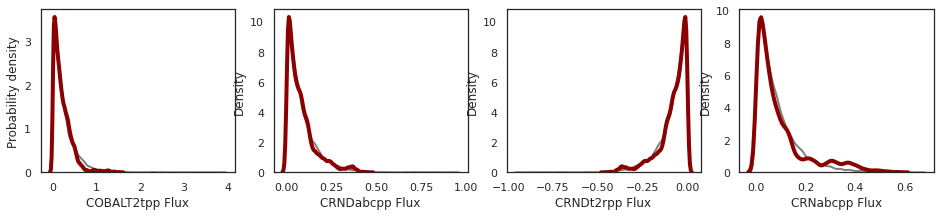

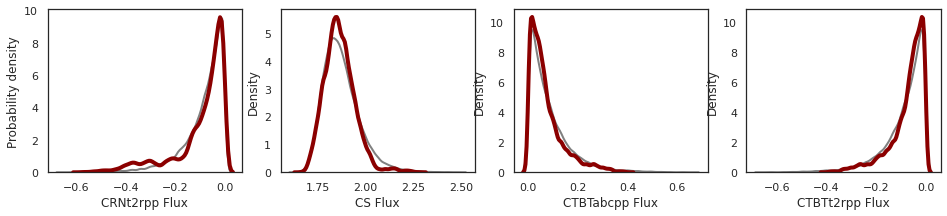

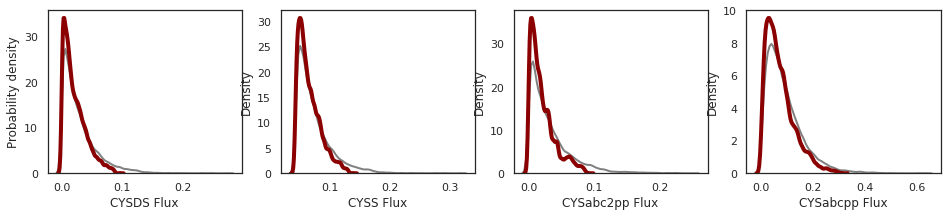

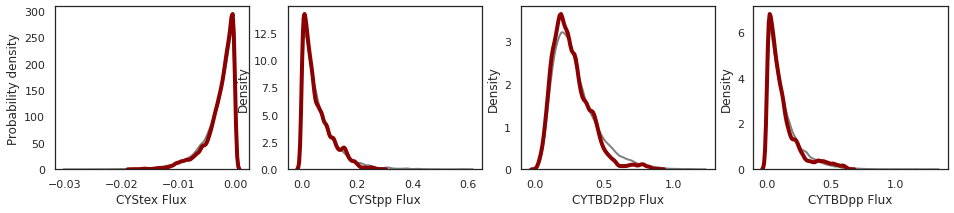

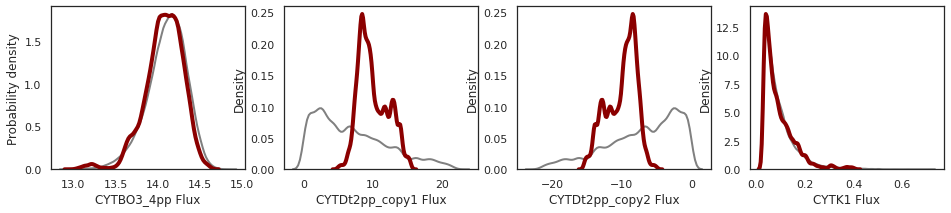

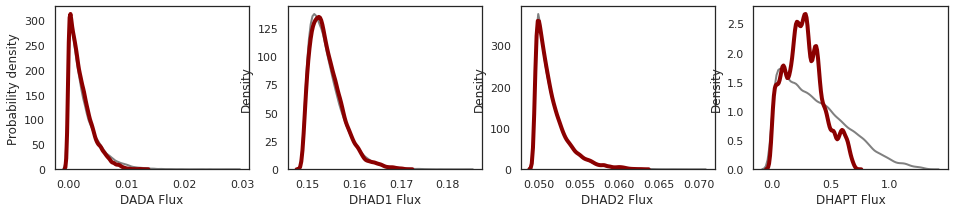

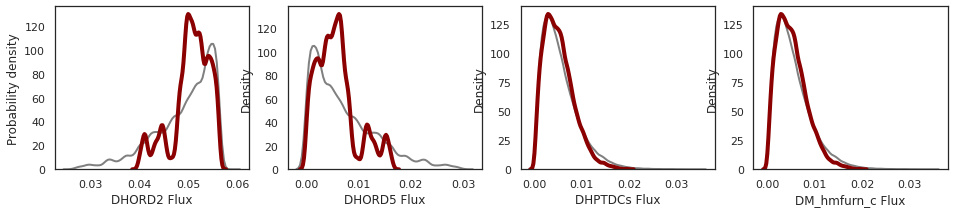

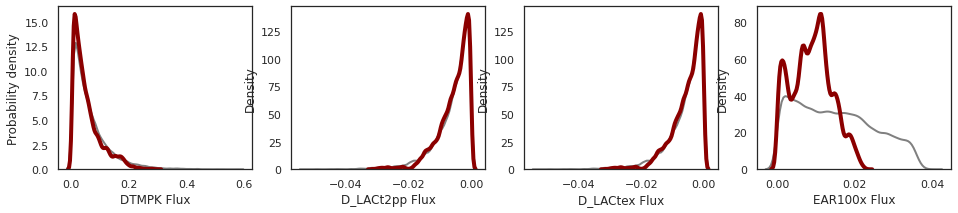

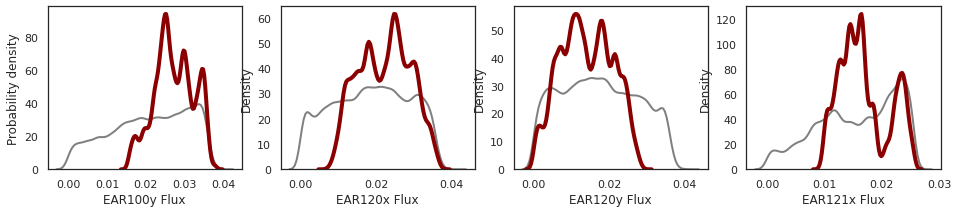

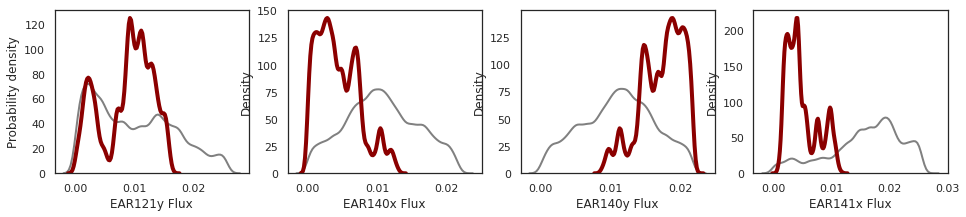

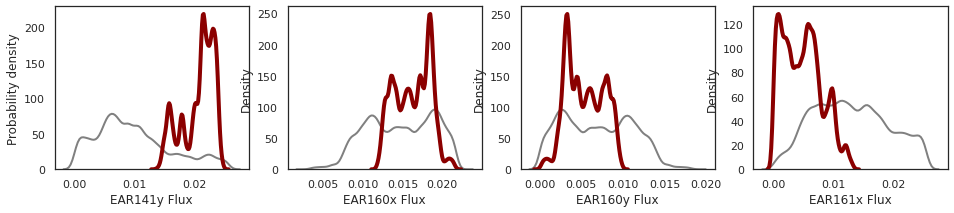

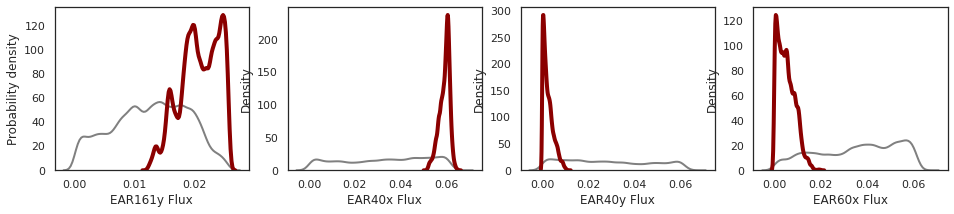

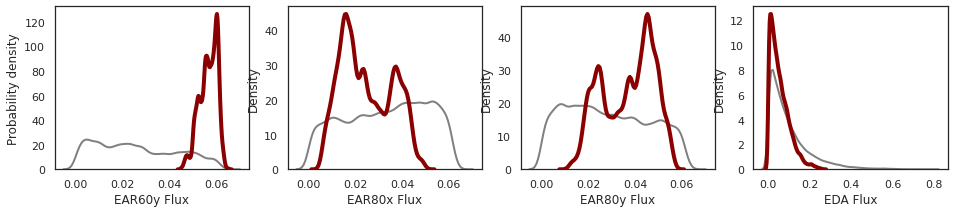

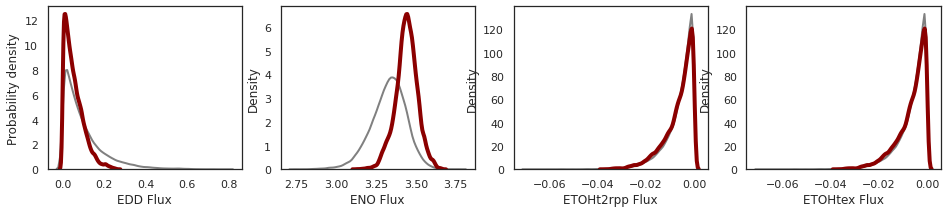

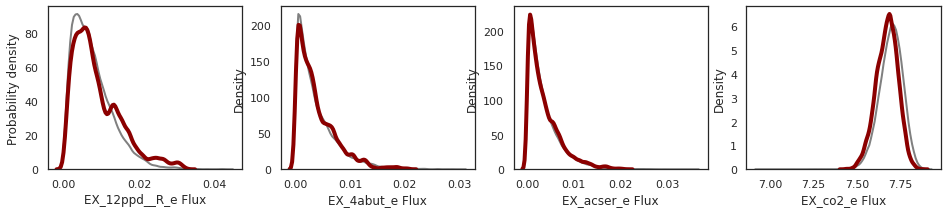

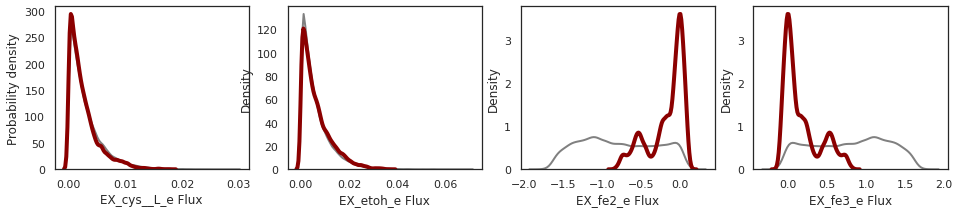

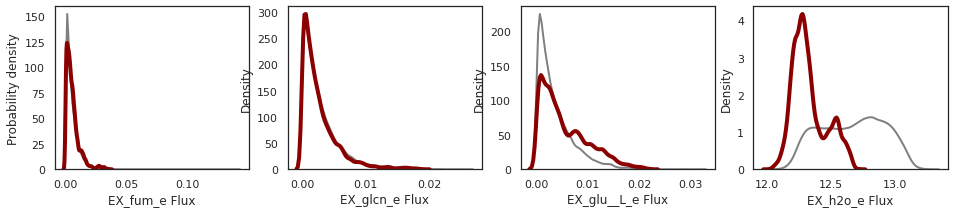

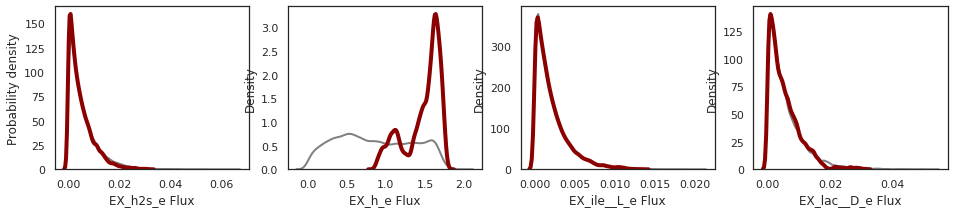

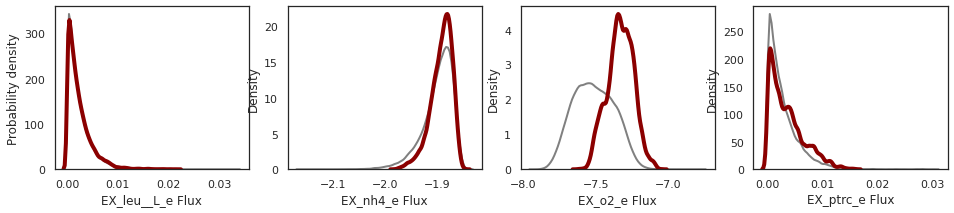

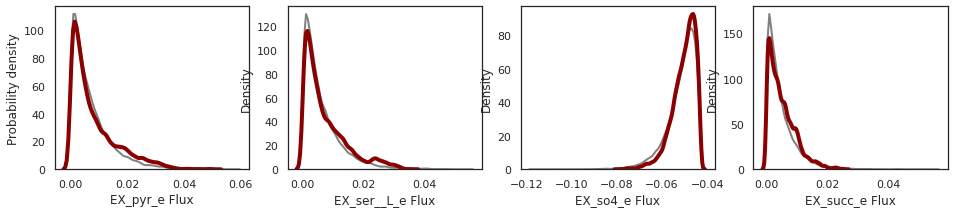

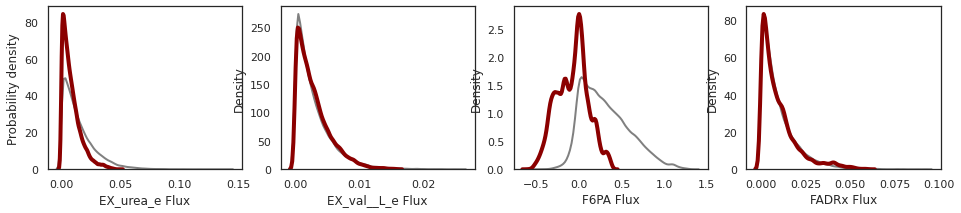

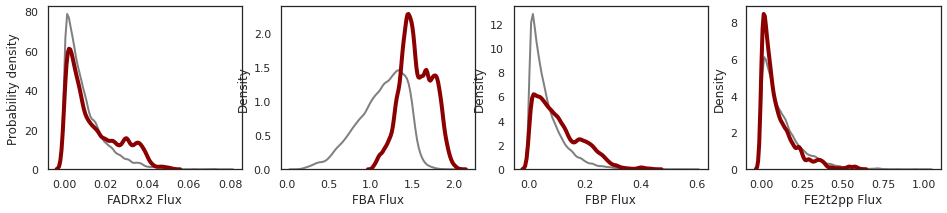

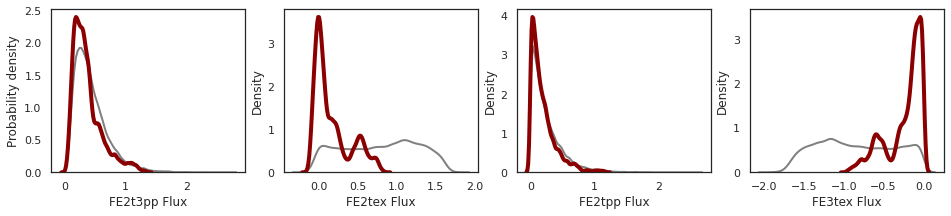

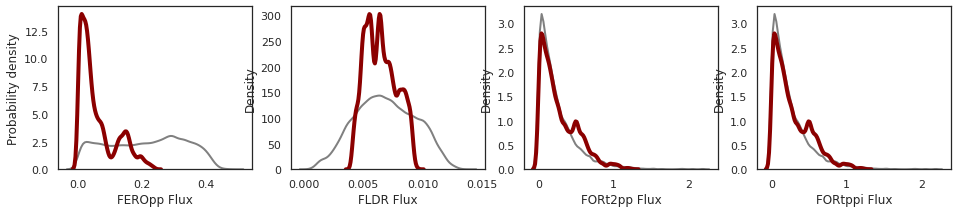

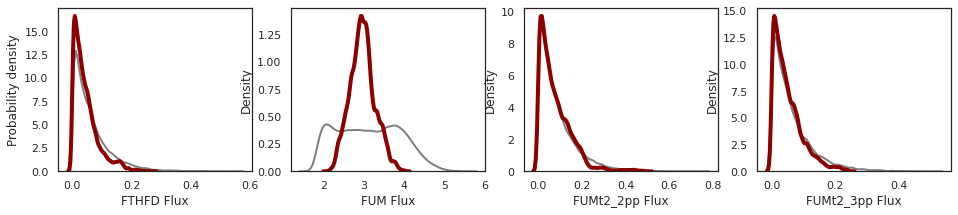

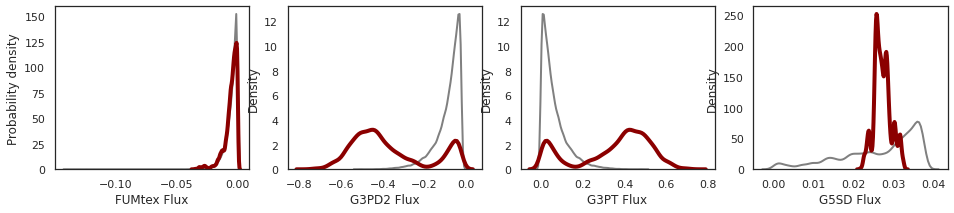

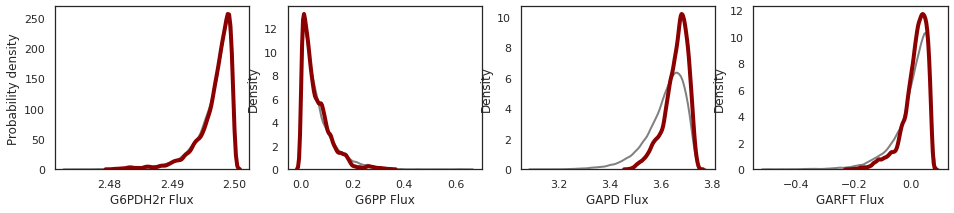

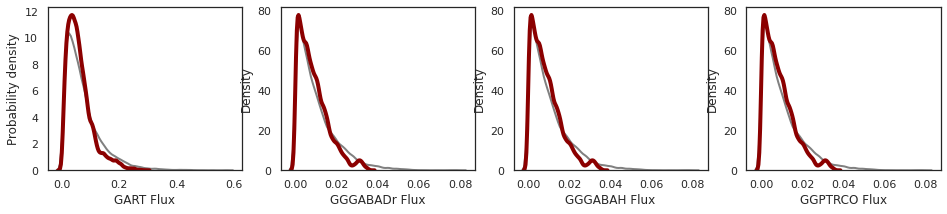

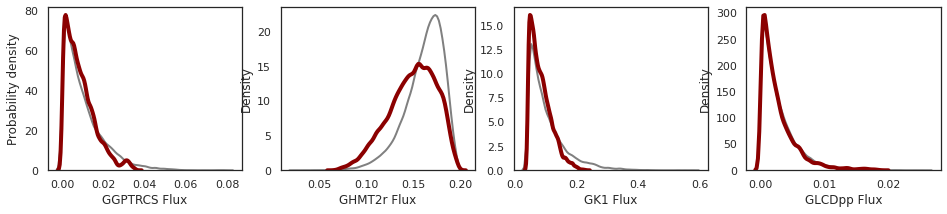

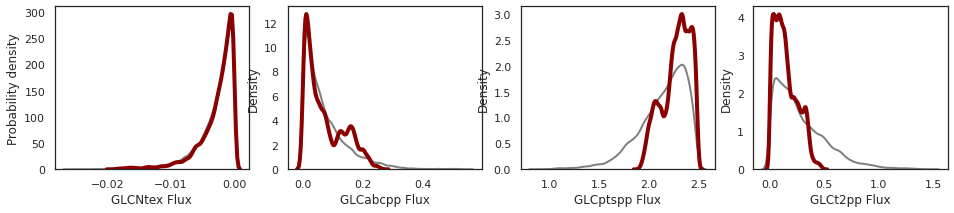

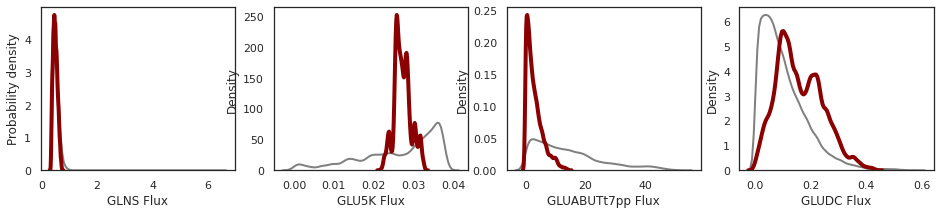

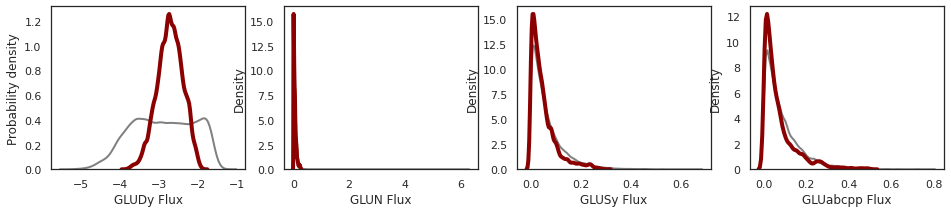

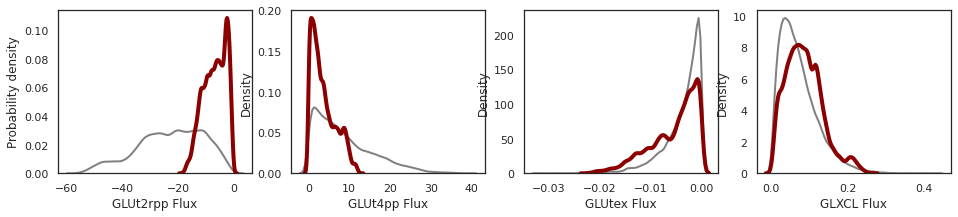

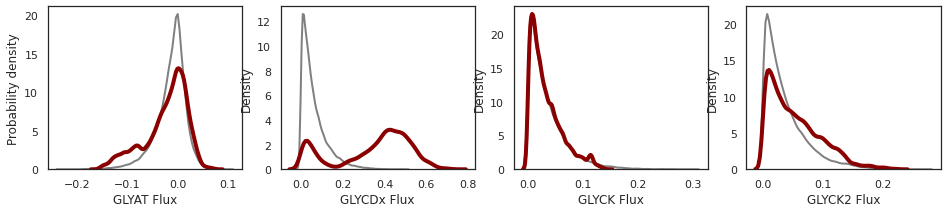

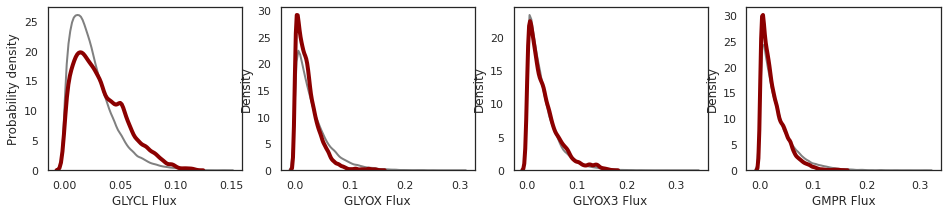

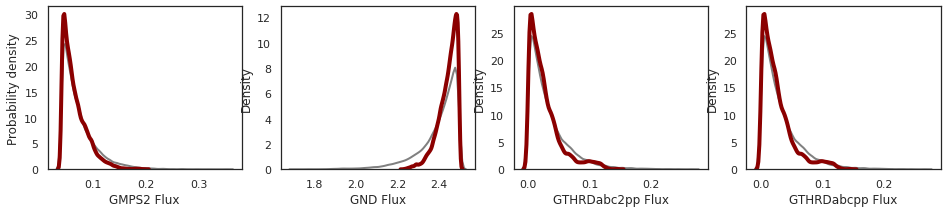

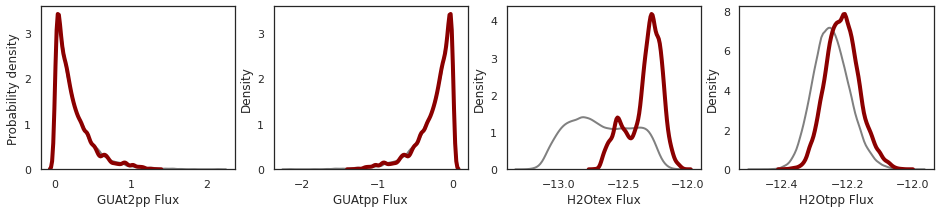

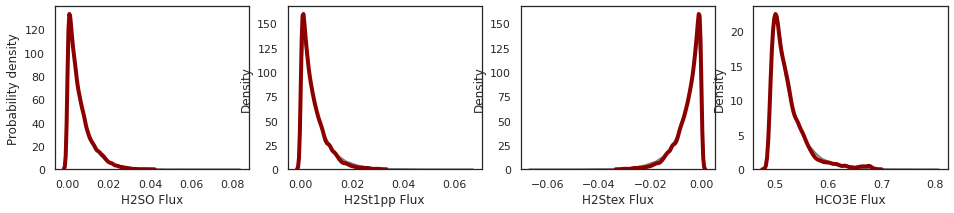

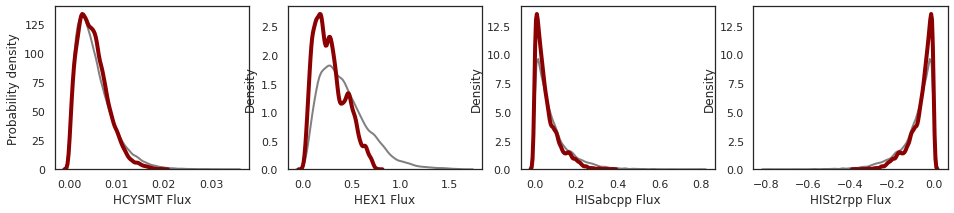

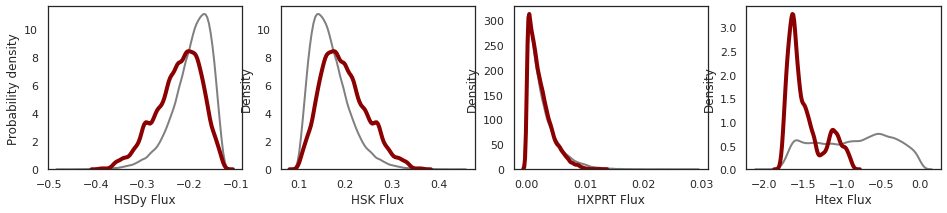

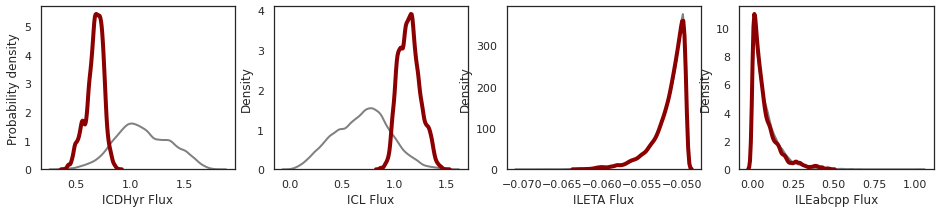

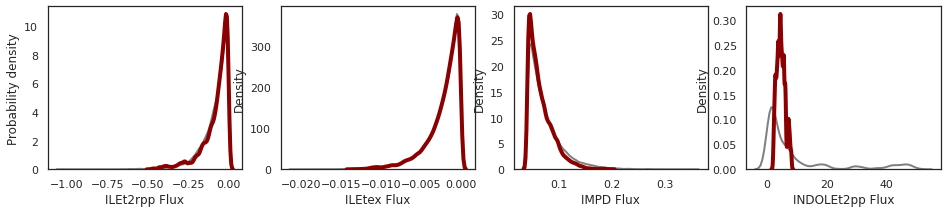

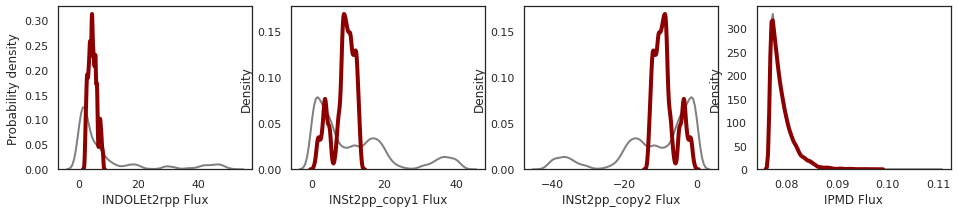

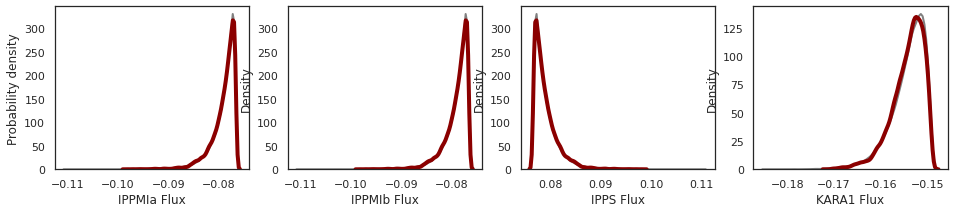

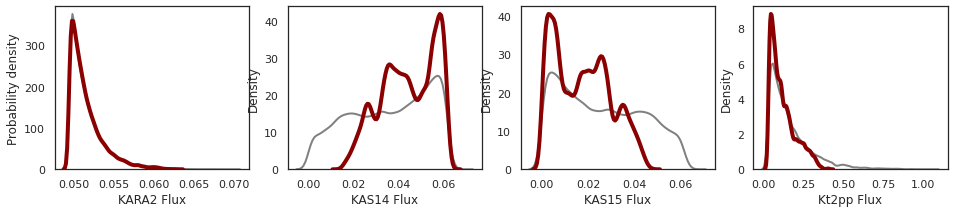

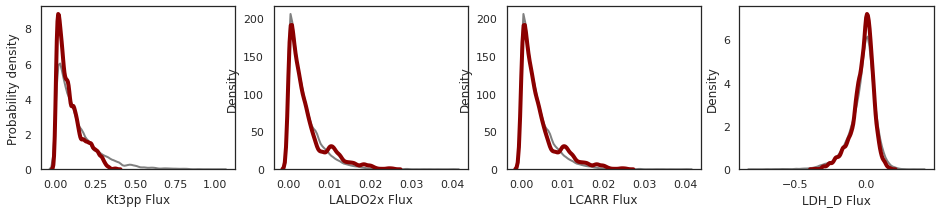

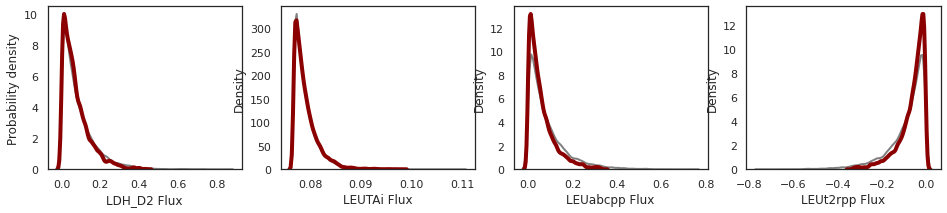

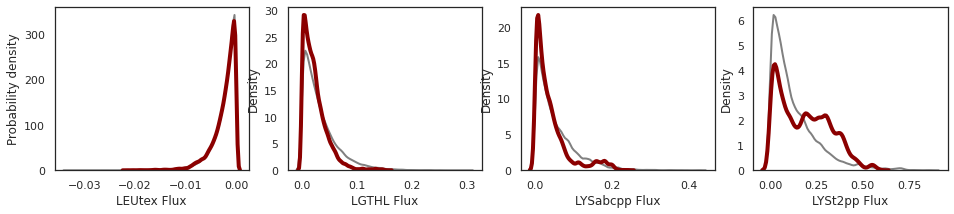

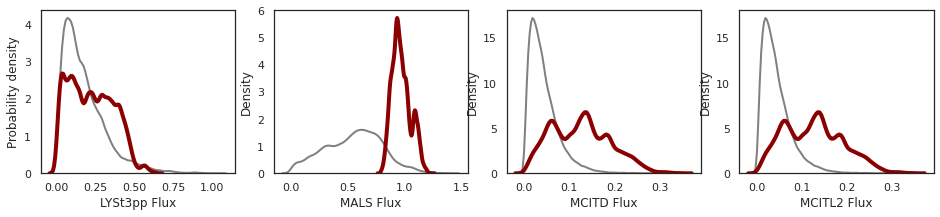

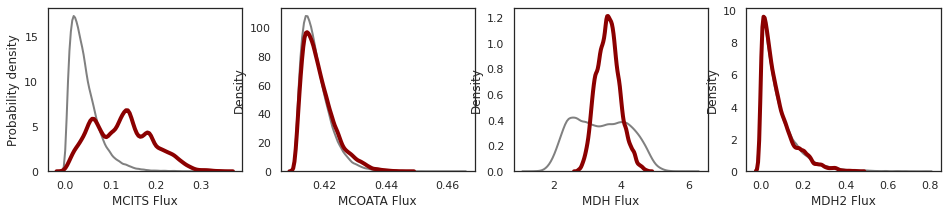

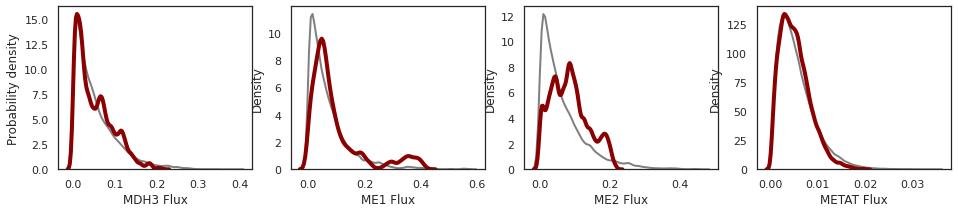

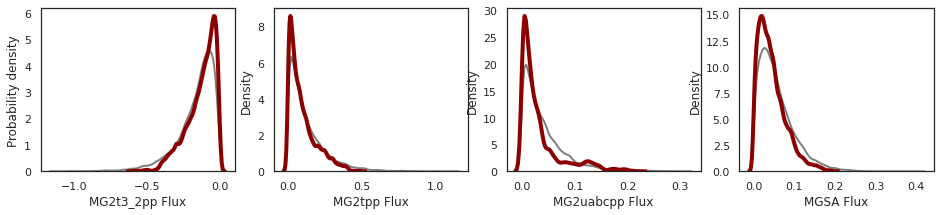

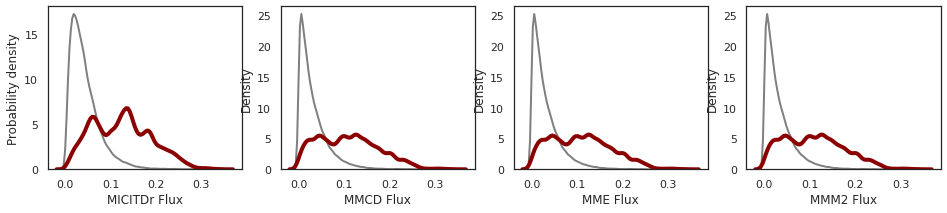

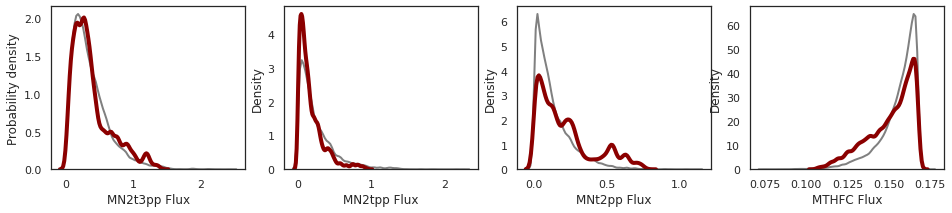

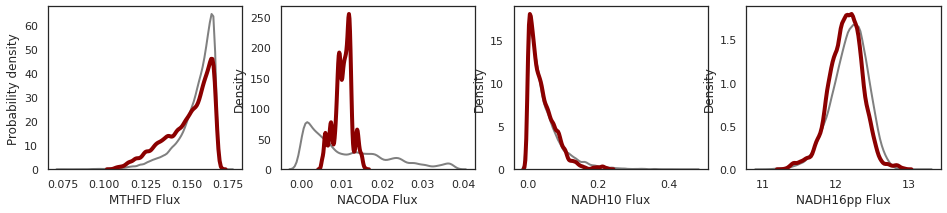

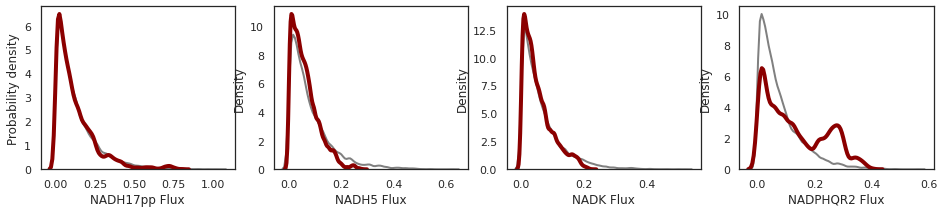

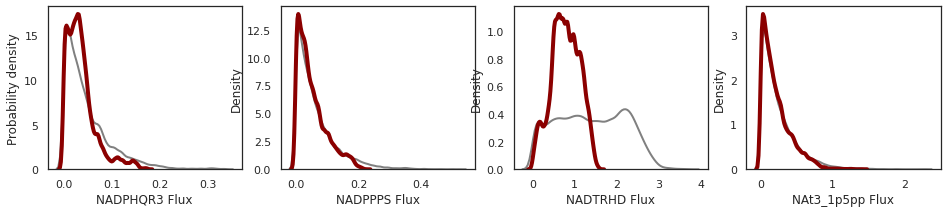

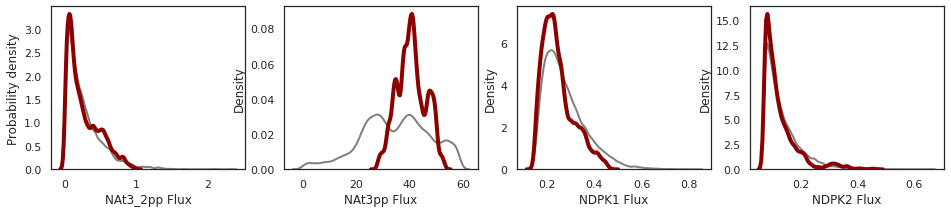

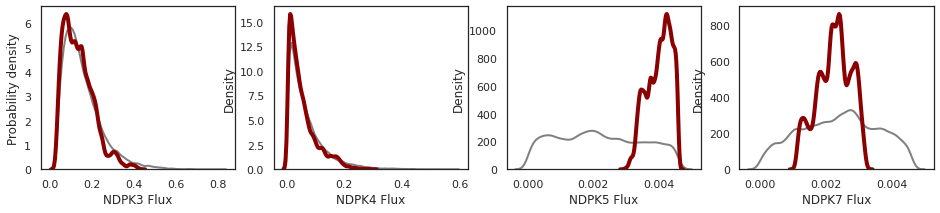

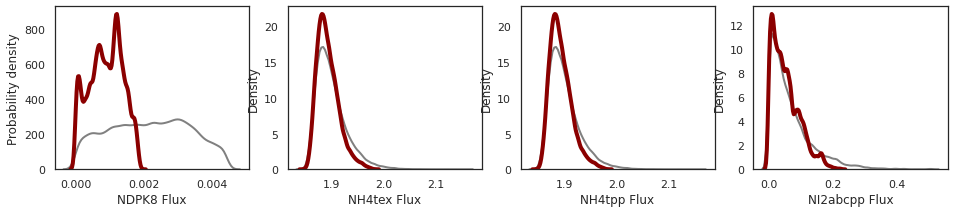

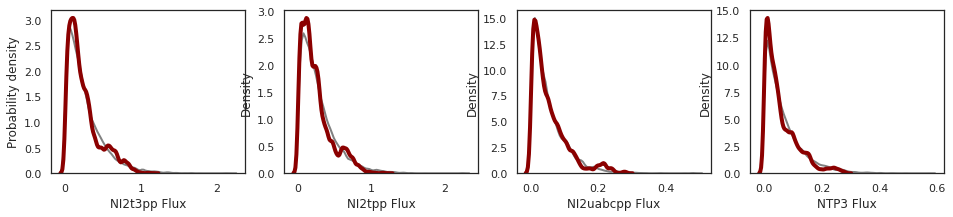

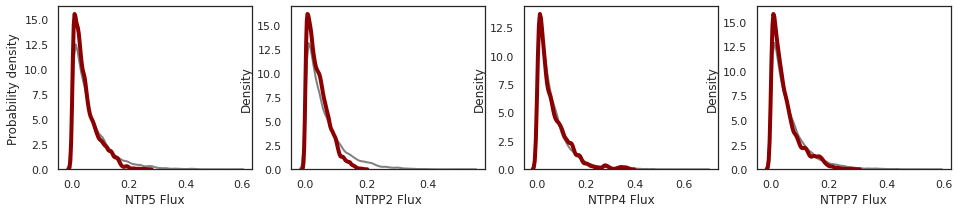

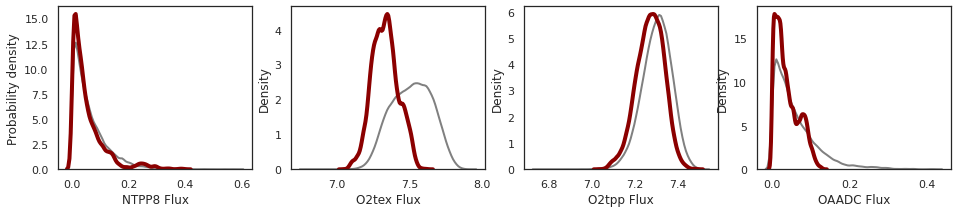

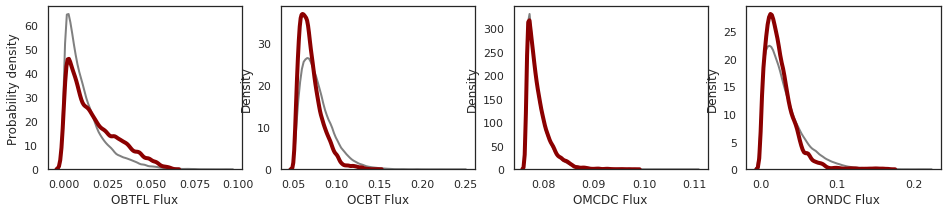

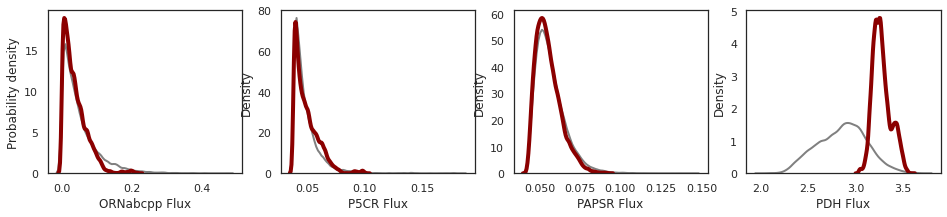

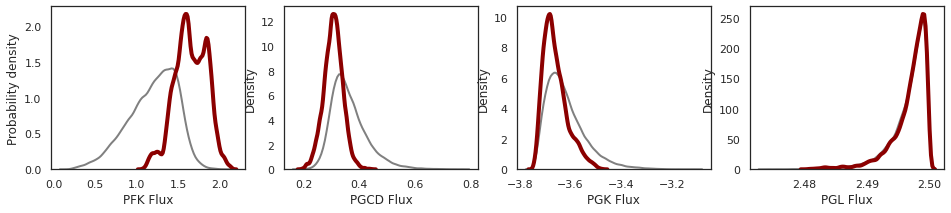

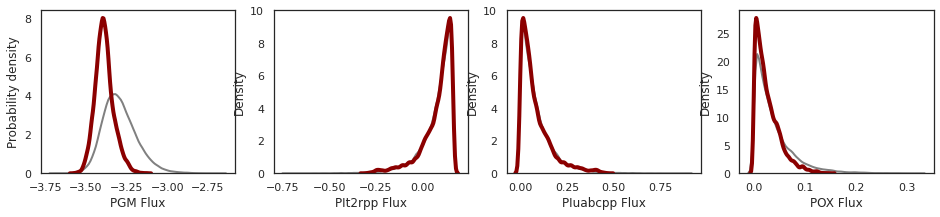

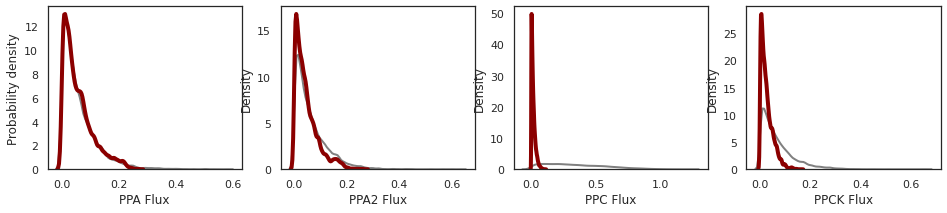

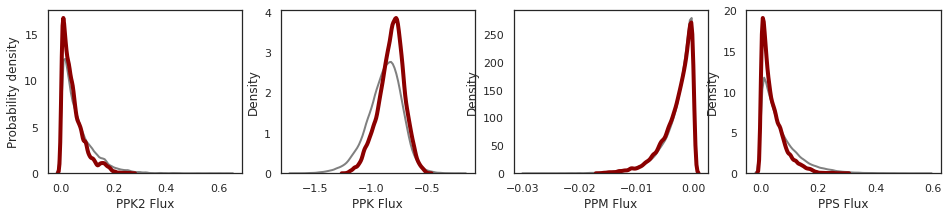

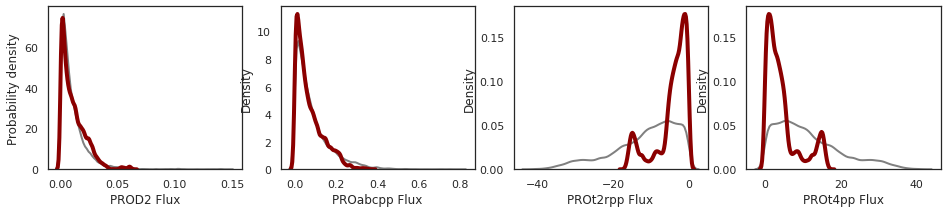

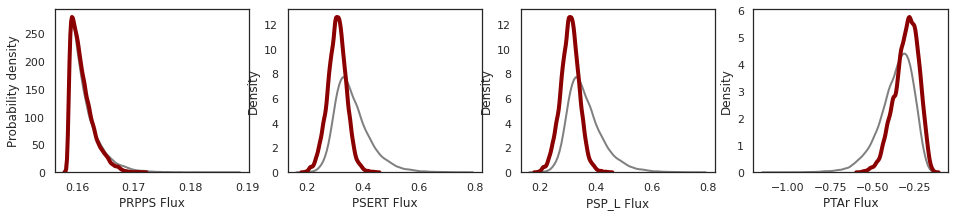

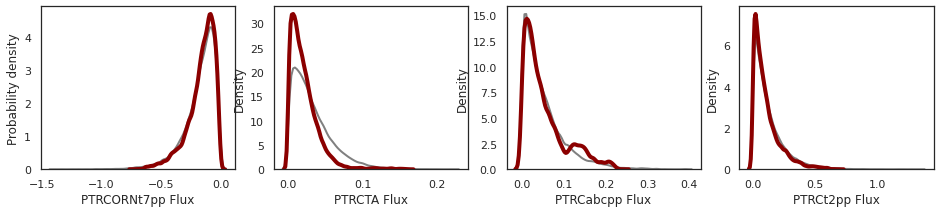

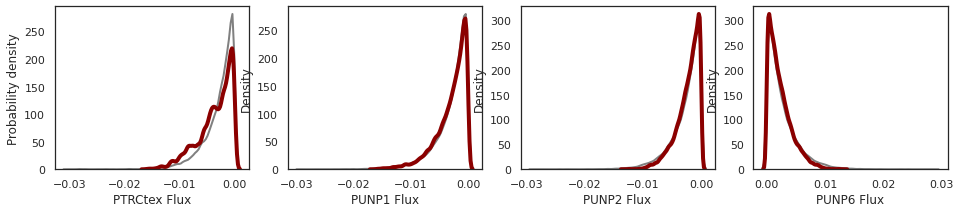

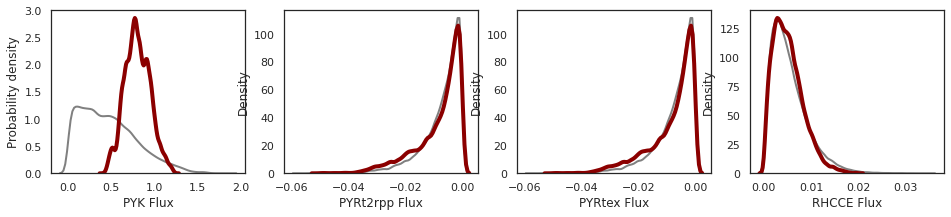

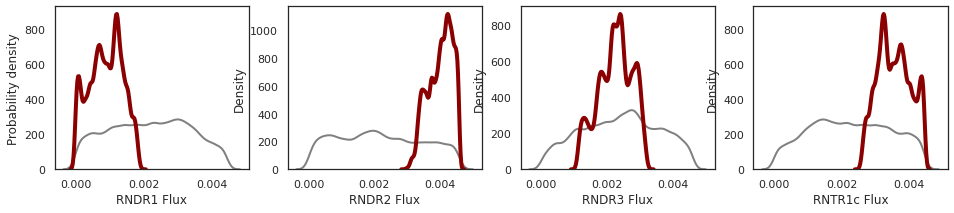

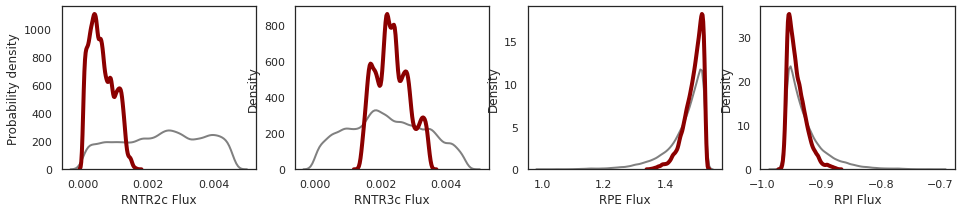

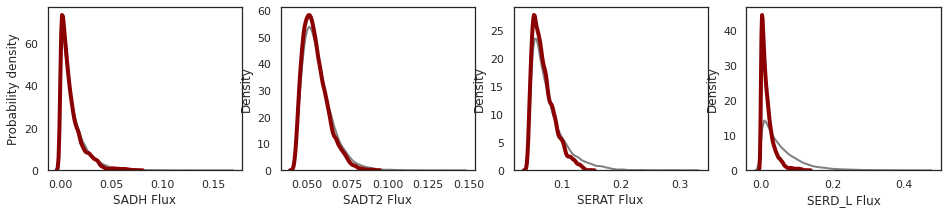

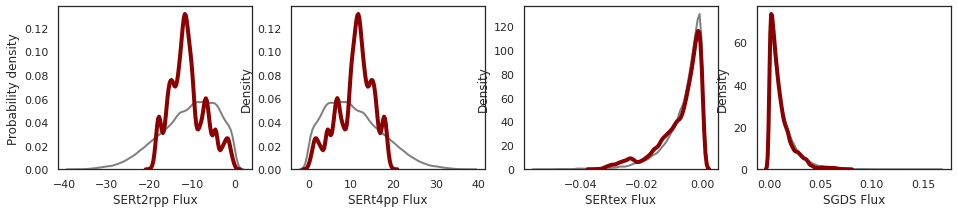

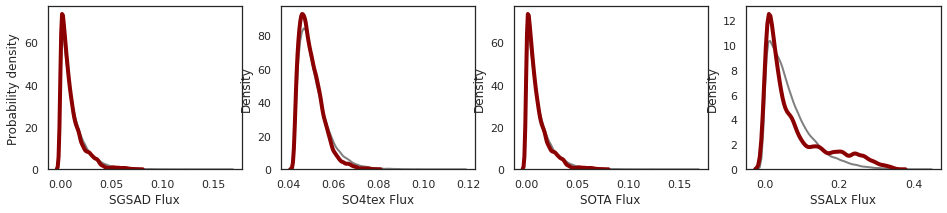

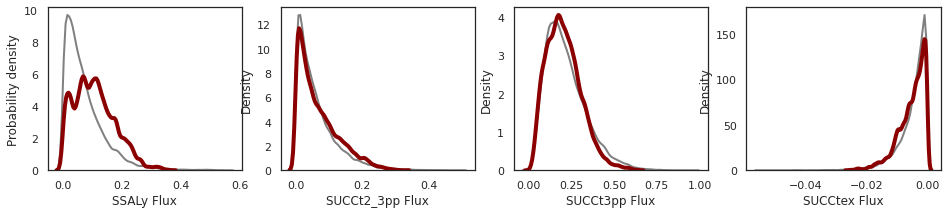

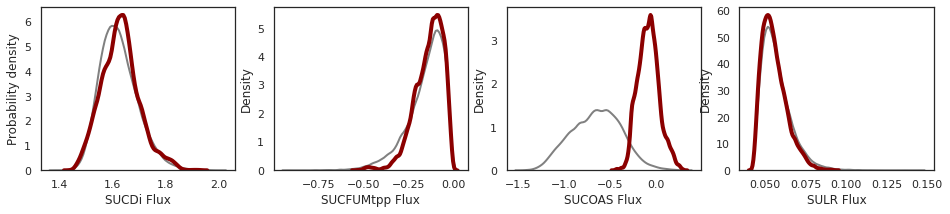

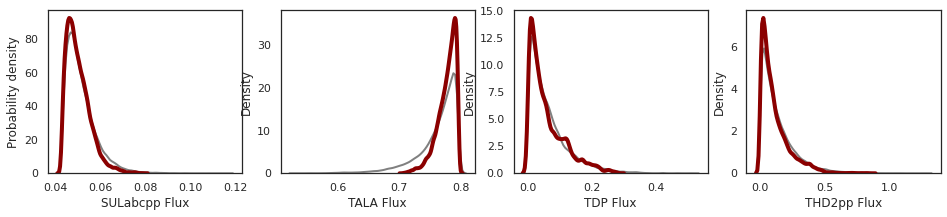

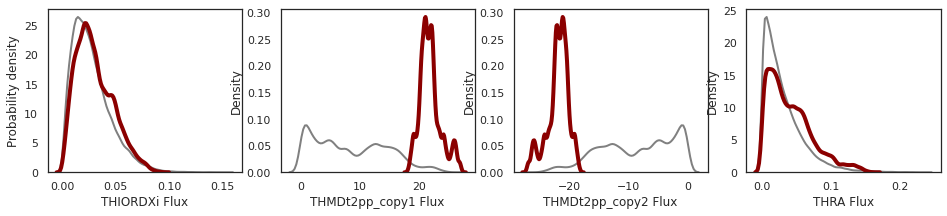

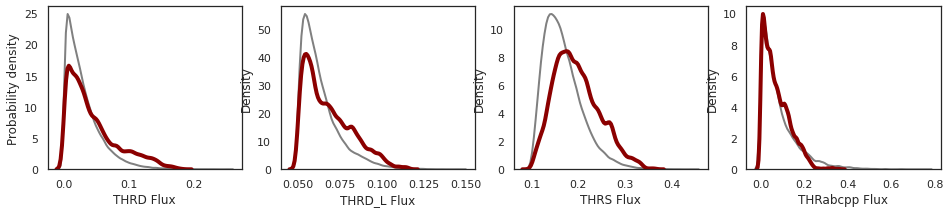

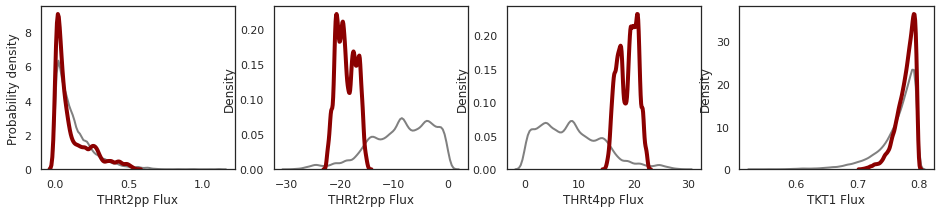

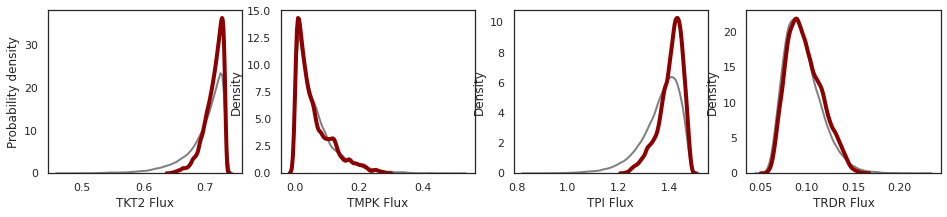

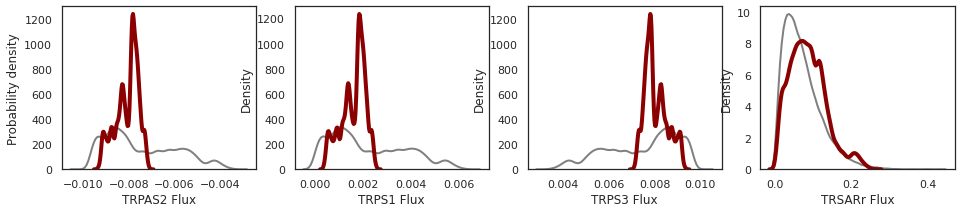

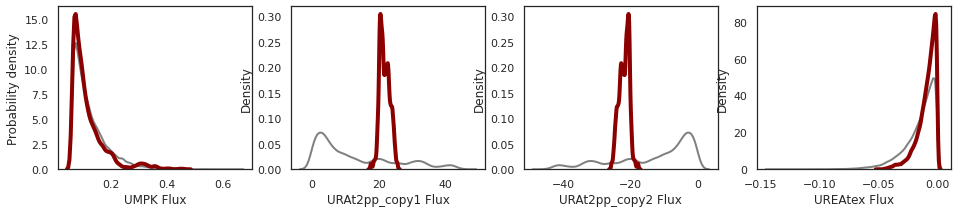

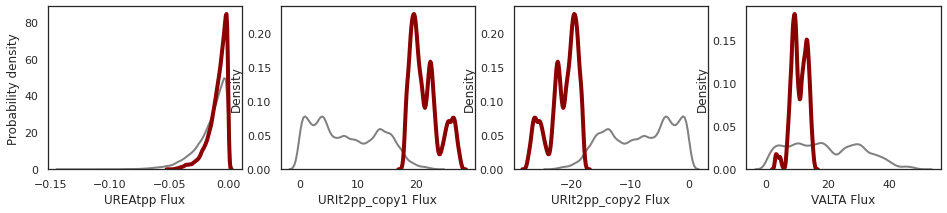

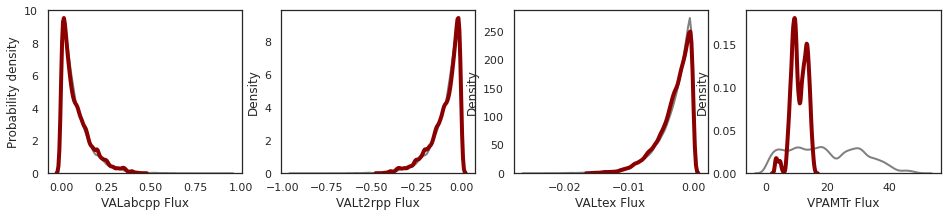

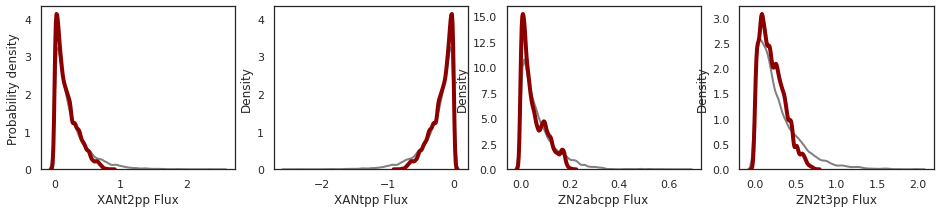

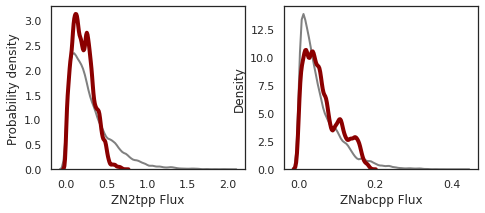

In [29]:
# plot marginals

cols = 4
rows = math.ceil(netUniform.shape[1]/cols)

matplotlib.rcParams['figure.figsize'] = (16,3)
for j in range(0, rows):
    for k in range(0, cols):
        i = (j*cols) + k
        if i > (netUniform.shape[1] - 1):
            break
        # try:
        plt.subplot(1, cols, k + 1)
        sns.kdeplot(netUniform.iloc[0::warmupSampleThinning,i], lw=2, gridsize=100, color="grey", label="Uniform")
        sns.kdeplot(netSamples.iloc[0::realSampleThinning,i], lw=4, gridsize=100, color="darkred")
        # except:
            # continue

        plt.xlabel(netUniform.columns[i] + " Flux")
        if k == 0:
            plt.ylabel("Probability density")
    plt.show()

### Analyze sampler convergence with Gelman–Rubin diagnostic

Each chain sampling from the posterior effectively starts at a different random location from a uniform sample of the flux space because of the warmupSamples, which end at a different spot depending on the random seed. Values close to 1.0 (for example 1.1 or less) typically indicate convergence.

In [30]:
samplesPerChain = configData['bayesianSamplesPerTask']

In [31]:
# compute stat with net fluxes only
# comment these out if we want to analyze each direction independently
numpysamples = np.array(realSamples)
data = np.subtract(numpysamples[:,0::2], numpysamples[:,1::2])
data.shape

(400000, 719)

In [32]:
# compute Gelman–Rubin diagnostic

# define a number of 'burn in' samples which will be discarded, and not used to compute
# the GR diagnostic
burnin = int(samplesPerChain/4) # discard the first quarter samples

# reshape data into a 3D array where each 1st dimension is a chain as used by pymc
samples = data.shape[0]
# chains = len(seeds)
data3D = np.reshape(data, newshape=(chains, samplesPerChain,-1), order='C')
thin = int(math.ceil(samplesPerChain/10))

# iteratively analyze convergence with stepsize thin
# using the gelman_rubin function from pymc
grStats = np.zeros(shape=(int((samplesPerChain - burnin)/thin), data3D.shape[2]), dtype=np.float64, order='C')
for point in range(1, int((samplesPerChain - burnin)/thin) + 1):
    thisPoint = int(point * thin) + burnin
    subset = np.take(data3D, range(burnin + 1, thisPoint), 1)
    print(subset.shape)
    grStats[point - 1] = gelman_rubin(subset)

(4, 9999, 719)


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/pymc/diagnostics.py:625 RuntimeWarning: invalid value encountered in double_scalars


(4, 19999, 719)
(4, 29999, 719)
(4, 39999, 719)
(4, 49999, 719)
(4, 59999, 719)
(4, 69999, 719)


<AxesSubplot:>

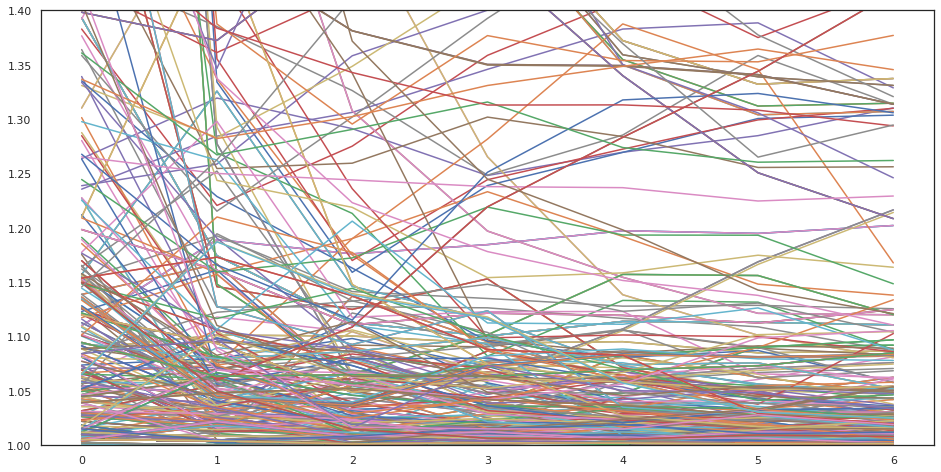

In [33]:
# plot the Gelman–Rubin diagnostic over the course of the simulation

matplotlib.rcParams['figure.figsize'] = (16,8)
# pd.DataFrame(grStats[100:,:]).plot(legend=False, ylim=(1,10))
pd.DataFrame(grStats).plot(legend=False, ylim=(1,1.4))

In [34]:
# print out final convergence by reaction name
# we drop all NAs, as they are all reverse directions for non reversible reactions
GRbyVariable = pd.DataFrame(grStats[grStats.shape[0] - 1], index=[v.name for v in model.variables][0::2], columns=['GR']).dropna()
GRbyVariable[rxnsWithVariance].sort_values(by='GR')

/tmp/ipykernel_32626/3340616574.py:4 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR
ETOHt2rpp        1.000461
ALCD2x           1.000461
ETOHtex          1.000461
EX_etoh_e        1.000461
LEUabcpp         1.000540
LEUt2rpp         1.000602
THD2pp           1.002058
PGL              1.002116
G6PDH2r          1.002116
NDPK4            1.002291
NTPP7            1.002291
DTMPK            1.002291
GLCDpp           1.002386
EX_glcn_e        1.002386
GLCNtex          1.002386
GLUabcpp         1.002550
NAt3_1p5pp       1.002552
CYSabcpp         1.003117
DADA             1.003470
HXPRT            1.003470
PUNP2            1.003470
PUNP6            1.003470
ADSS             1.003633
ADSL1r           1.003633
CBMKr            1.003839
CTBTabcpp        1.003865
CTBTt2rpp        1.003865
IMPD             1.003926
GMPS2            1.003926
GMPR             1.003937
PRPPS            1.003956
COBALT2tpp       1.004104
COBALT2t3pp      1.004104
ILEt2rpp         1.004189
ILEabcpp         1.004642
HCYSMT           1.004765
RHCCE            1.004765
AHCYSNS          1.004765
DM_hmfurn_c      1.004765
DHPTDCs          1.004765
METAT            1.004766
ALDD2x           1.005037
NADPHQR3         1.005439
ADNK1            1.005480
PUNP1            1.005480
PPM              1.005480
GTHRDabcpp       1.005509
GTHRDabc2pp      1.005509
SUCCt2_3pp       1.005632
CRNDabcpp        1.005664
CRNDt2rpp        1.005664
EX_cys__L_e      1.005965
CYStex           1.005965
CYStpp           1.006003
H2SO             1.006625
EX_nh4_e         1.007542
NH4tex           1.007542
NH4tpp           1.007542
NADH5            1.007551
ACSERtpp         1.007616
EX_acser_e       1.007616
ACSERtex         1.007616
NTPP4            1.007958
CYTK1            1.007969
XANt2pp          1.008003
XANtpp           1.008003
POX              1.008979
PTRCt2pp         1.009107
CYSabc2pp        1.009326
ACCOAC           1.009830
MCOATA           1.009830
NAt3_2pp         1.009962
DHAD2            1.009997
ACHBS            1.009997
ILETA            1.009997
KARA2            1.009997
PPK2             1.010175
PPA2             1.010175
ILEtex           1.010212
EX_ile__L_e      1.010212
ARGORNt7pp       1.010678
ASNt2rpp         1.010936
ASNabcpp         1.010936
FUMt2_2pp        1.010946
ARGt3pp          1.011665
NI2abcpp         1.011684
EX_val__L_e      1.011908
VALtex           1.011908
PAPSR            1.012308
ADSK             1.012308
BPNT             1.012308
SADT2            1.012308
SULR             1.012308
ASNS1            1.012902
NDPK3            1.013325
FUMt2_3pp        1.014104
NI2t3pp          1.014510
SUCFUMtpp        1.015083
LYSabcpp         1.015403
LEUtex           1.015513
EX_leu__L_e      1.015513
EX_ptrc_e        1.015524
PTRCtex          1.015524
LEUTAi           1.015572
OMCDC            1.015572
IPPS             1.015572
IPMD             1.015572
IPPMIa           1.015572
IPPMIb           1.015572
ORNabcpp         1.015906
NTP5             1.016137
EX_ser__L_e      1.016847
SERtex           1.016847
NI2uabcpp        1.016959
NADPPPS          1.018134
NADK             1.018134
ZN2tpp           1.019017
MG2uabcpp        1.019115
H2Stex           1.019174
H2St1pp          1.019174
EX_h2s_e         1.019174
MDH2             1.019469
TDP              1.019492
TMPK             1.019492
Kt2pp            1.019700
Kt3pp            1.019706
KARA1            1.020159
DHAD1            1.020159
ACLS             1.020159
PTRCORNt7pp      1.020747
CYTBD2pp         1.020827
CD2t3pp          1.021810
CD2tpp           1.021810
GLUSy            1.022008
MGSA             1.022287
ASNS2            1.022519
EX_so4_e         1.022794
SO4tex           1.022794
SULabcpp         1.022794
PROabcpp         1.023286
CYTBDpp          1.024196
MG2t3_2pp        1.024286
GGGABADr         1.024286
GGPTRCO          1.024286
GGGABAH          1.024286
GGPTRCS          1.024286
NI2tpp           1.024397
GLYOX            1.024630
LGTHL            1.024630
VALt2rpp         1.024933
VALabcpp         1.025368
PIt2rpp          1.025550
PIuabcpp         1.025735
MG2tpp           1.

In [35]:
GRbyVariable.shape

(710, 1)

In [36]:
(GRbyVariable[rxnsWithVariance] < 1.10).sum()

/tmp/ipykernel_32626/3883560918.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR    257
dtype: int64

In [37]:
(GRbyVariable[rxnsWithVariance] > 1.10).sum()

/tmp/ipykernel_32626/1197693162.py:1 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GR    181
dtype: int64